# 03. Errors calculation
We are going to calulate the errors (differences) between the `FUEL_DEPLETED` and the `TOTAL_FUEL_USED`. The main objective is to understand the variations they might have so we can later pinpoint the outliers (leaks).

The process we are going to follow is:
1. Remove flights with less than 2 observations for `FUEL_USED`
2. Fill the missing values for `FUEL_USED_i` columns using a linear regression model
3. Calculate the `FUEL_DEPLETED` metric, which is the maximum `VALUE_FOB` minus the current `VALUE_FOB`. The formula is:
$$FUEL\_DEPLETED = \max_{i=1}^{n} VALUE\_FOB_i - VALUE\_FOB_n$$
4. Calculate the `TOTAL_FUEL_USED` metric, which is the sum of all `FUEL_USED_i` columns. The formula is:
$$TOTAL\_FUEL\_USED = \sum_{i=1}^{n} FUEL\_USED_i$$
5. Calculate the `ERROR` metric, which is the difference between `FUEL_DEPLETED` and `TOTAL_FUEL_USED`. The formula is:
$$ERROR = FUEL\_DEPLETED - TOTAL\_FUEL\_USED$$



In [105]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from icecream import ic


import sys
sys.path.append('python_scripts')

import capstone_functions as cf
import importlib
importlib.reload(cf)

import warnings
warnings.filterwarnings('ignore')

## 3.1. Remove flights with less than 2 observations for `FUEL_USED`

In [74]:
# We will read the data, we will only read the columns we need
columns = ['Flight', 'MSN', 'UTC_TIME', 'FLIGHT_PHASE_COUNT', 'FW_GEO_ALTITUDE',
           'FUEL_USED_1', 'FUEL_USED_2', 'FUEL_USED_3', 'FUEL_USED_4',
           'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3', 'VALUE_FUEL_QTY_FT4',
           'VALUE_FOB']

# Define the data types
columns_dtypes = {'Flight': 'str', 'MSN': 'str',
                  'FLIGHT_PHASE_COUNT': 'float16', 'FW_GEO_ALTITUDE': 'float32',
                  'FUEL_USED_1': 'float32', 'FUEL_USED_2': 'float32',
                  'FUEL_USED_3': 'float32', 'FUEL_USED_4': 'float32',
                  'VALUE_FUEL_QTY_FT1': 'float32', 'VALUE_FUEL_QTY_FT2': 'float32',
                  'VALUE_FUEL_QTY_FT3': 'float32', 'VALUE_FUEL_QTY_FT4': 'float32',
                  'VALUE_FOB': 'float64'}

# File path
file_path = 'data/raw_data/msn_12_fuel_leak_signals_preprocessed.csv'

df = cf.read_and_prepare(file_path, columns, columns_dtypes, parse_dates=['UTC_TIME'], delimiter=';', altitude_filter=True)


In [60]:
value_cols = ['FUEL_USED_1', 'FUEL_USED_2', 'FUEL_USED_3', 'FUEL_USED_4']

df_filtered = cf.keep_usable_flights(df, 'id', value_cols, 1)

total_ids = df['id'].nunique()
ids_kept = df_filtered['id'].nunique()

ic(total_ids)
ic(ids_kept)

initial_shape = df.shape
final_shape = df_filtered.shape

ic(initial_shape)
ic(final_shape)

ic| total_ids: 170
ic| ids_kept: 36
ic| initial_shape: (1850527, 14)
ic| final_shape: (481990, 14)


(481990, 14)

## 3.2. Fill the missing values for `FUEL_USED_i` columns using a linear regression model

In [87]:
df_complete = cf.fill_missing_values_all_flights(df=df_filtered)

df_complete.head()

,UTC_TIME,FUEL_USED_2,FUEL_USED_3,FUEL_USED_4,FW_GEO_ALTITUDE,VALUE_FOB,VALUE_FUEL_QTY_FT1,VALUE_FUEL_QTY_FT2,VALUE_FUEL_QTY_FT3,VALUE_FUEL_QTY_FT4,FLIGHT_PHASE_COUNT,FUEL_USED_1,id,duration
2238984,2017-02-13 12:02:20,526.165325,499.105158,501.371539,23009.0,26770.0,1798.0,2633.0,2624.0,1821.0,8.0,448.966810,F-RBAE_322.0,0.0
2238985,2017-02-13 12:02:21,526.450360,498.806004,501.635471,23036.0,26765.0,1797.0,2633.0,2622.0,1820.0,8.0,448.724926,F-RBAE_322.0,1.0
2238986,2017-02-13 12:02:22,526.735394,498.796600,501.899404,23061.0,26762.0,1797.0,2633.0,2621.0,1819.0,8.0,449.046839,F-RBAE_322.0,2.0
2238987,2017-02-13 12:02:23,526.691497,499.076946,502.163336,23087.0,26757.0,1796.0,2632.0,2621.0,1818.0,8.0,448.804955,F-RBAE_322.0,3.0
2238988,2017-02-13 12:02:24,526.647599,499.067542,502.463304,23110.0,26753.0,1795.0,2631.0,2620.0,1818.0,8.0,448.563070,F-RBAE_322.0,4.0


## 3.3 Data Enrichment
Add the following columns:
- `FUEL_DEPLETION`: Difference between the `VALUE_FOB_MAX` and the current `VALUE_FOB`
- `FUEL_USED_TOT`: Sum of all `FUEL_USED_i` columns
- `FUEL_ERROR`: Difference between the `FUEL_DEPLETION` and the `FUEL_USED_TOT`
- `FUEL_ERROR_DIFF`: Difference between the `FUEL_ERROR` and the `FUEL_ERROR` of the previous observation

In [88]:
df_enriched = cf.add_fuel_columns(df_complete, col1='FUEL_DEPLETION_SMOOTH', col2='FUEL_USED_TOT')
df_enriched.dropna(inplace=True)

## 3.4. Statistical tests
We will perform for each id two statistical tests:
1. ADF test for stationary: we will check if the errors of the rates are stationary. In case they present a trend it means that the rate of one fuel measurement is different from the other and keeps changing over time. This is a sign of a leak which keeps getting worse over time.
2. One-sample t-test: we will check if the errors time series are symmetrically distributed around zero. In case they are not, it means that the slope of one of the fuel measurements (`FUEL_DEPLETED` or `FUEL_USED_TOT`) is different from the other. This is a sign of a leak, since the fuel is being used at a different rate than the one it is being depleted.

This will be done for each id, and the results will be stored in a dataframe with the following columns:
- `id`: the id of the flight
- `adf_test`: the result of the ADF test
- `p_value_adf`: the p-value of the ADF test
- `wilcoxon_test`: the result of the Wilcoxon test
- `p_value_wilcoxon`: the p-value of the Wilcoxon test
- `leak`: a boolean indicating if the flight has a leak or not

### 3.4.1. ADF test

In [107]:
df_tests = cf.iterate_test(df_enriched, column_name = 'FUEL_ERROR_DIFF',
                           alpha=0.05, iterable_column='id')
df_tests
# F-RBAC_2169.0, (init: -0.36, end: -0.08)
# Review belly shape, try with inputting of missing value, or with time series adding altitude correction.
# Minimum amount of leak based on rate and duration that we are able to detect.

,id,mean,std,pval_adf,result_adf,lower_bound,upper_bound,contains_zero
0,F-RBAE_322.0,-0.007004,2.006393,4.541586e-24,1,-3.939462,3.925454,True
0,F-RBAE_323.0,-0.141596,0.450564,1.005691e-17,1,-1.024686,0.741494,True
0,F-RBAE_361.0,-0.049118,0.213267,9.129739e-18,1,-0.467114,0.368879,True
0,F-RBAE_367.0,-0.106038,1.256763,0.000000e+00,1,-2.569249,2.357173,True
0,F-RBAE_368.0,-0.048846,0.116863,1.522702e-20,1,-0.277892,0.180201,True
0,F-RBAE_371.0,-0.188649,0.159789,1.466818e-01,0,-0.501829,0.124531,True
0,F-RBAE_378.0,0.033767,0.225657,1.570245e-10,1,-0.408513,0.476047,True
0,F-RBAE_379.0,-0.317012,0.674470,8.328195e-05,1,-1.638949,1.004924,True
0,F-RBAE_380.0,-0.069210,6.457638,0.000000e+00,1,-12.725947,12.587527,True
0,F-RBAE_381.0,-0.058393,2.034169,3.995397e-29,1,-4.045292,3.928506,True


In [108]:
# Plot the time series for FUEL_DEPLETED and FUEL_USED_TOT
df_test = df_enriched[df_enriched['id']=='F-RBAE_441.0']
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_test['UTC_TIME'], y=df_test['FUEL_DEPLETION'], name='FUEL_DEPLETION'))
fig.add_trace(go.Scatter(x=df_test['UTC_TIME'], y=df_test['FUEL_USED_TOT'], name='FUEL_USED_TOT'))

fig.update_layout(title='FUEL_DEPLETED vs FUEL_USED_TOT',
                  xaxis_title='UTC_TIME',
                  yaxis_title='FUEL')

fig.show()

<AxesSubplot:>

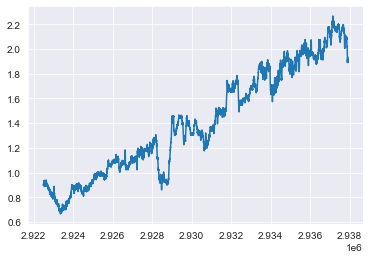

In [112]:
time_series = df_test['FUEL_ERROR_DIFF'] + df_test['duration']*0.0001
#time_series = df_test['FUEL_DEPLETION'] - df_test['FUEL_USED_TOT']
time_series.plot()

<AxesSubplot:>

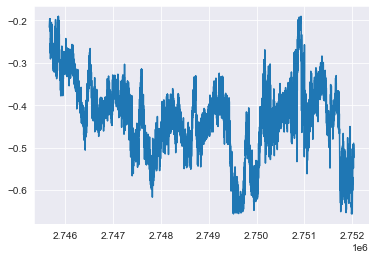

In [97]:
# Remove outliers from 0.01 to 0.99 quantiles
time_series = time_series[(time_series > time_series.quantile(0.01)) & (time_series < time_series.quantile(0.99))]
time_series.plot()

In [114]:
# Perform ADF test for FUEL_ERROR_DIFF
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_1samp

# We will remove the outliers of the time series
alpha = 0.05
adf_result = adfuller(time_series)

p_value = adf_result[1]

# H0: the series is not stationary
# H1: the series is stationary
adf_conclusion = 1 if p_value < alpha else 0

print(p_value, adf_conclusion)

0.7022016316781323 0


In [63]:
# We will check t-test for FUEL_ERROR_DIFF on mean equal to zero


ttest_result = ttest_1samp(time_series, 0)

p_value = ttest_result[1]

# H0: the mean of the series is zero
# H1: the mean of the series is not zero
ttest_conclusion = 1 if p_value < alpha else 0

print(p_value, ttest_conclusion)

0.4164517726676008 0


In [50]:
time_series.describe()

count    23741.000000
mean        -0.001219
std          1.330579
min         -3.177855
25%         -1.177855
50%         -0.177855
75%          0.822145
max          2.822145
Name: FUEL_ERROR_DIFF, dtype: float64

In [29]:
shapiro_result

ShapiroResult(statistic=0.953424334526062, pvalue=1.327381251068307e-27)